# **Problem Definition**

The aim of this project is to create a collaborative filtering-based movie recommendation system. Given a user’s favorite movie, the system will recommend a list of similar movies based on ratings data provided by other users. This approach does not require information about the content of the movies but instead relies on the behavior of other users to infer similarities between movies.

# Objectives:
Develop a movie recommendation system that suggests similar movies based on user ratings.
Implement collaborative filtering using K-Nearest Neighbors (KNN) to identify movies with similar user ratings.
Handle case-insensitivity in user input, ensuring the recommendation system is robust to variations in capitalization.

# Why This Problem?

With the vast number of movies available, finding relevant and enjoyable content can be challenging for users. Recommendation systems help users discover movies they’re likely to enjoy, based on their previous interactions or similar users’ interactions. Collaborative filtering is a powerful method to solve this problem because it effectively leverages user ratings to find similarities without needing extensive metadata about the movies themselves.

# Approach

**Data Preparation:**
Load movie and rating datasets.
Create a user-item matrix from the ratings data, representing each movie’s ratings by different users.
Filter out movies and users with too few ratings to reduce noise and ensure robust recommendations.

**Similarity Calculation Using KNN:**
Implement K-Nearest Neighbors with cosine similarity as the distance metric to find the most similar movies based on rating patterns.
Use sparse matrices for memory efficiency due to the large number of unrated entries in the dataset.

**Recommendation Retrieval:**
Define a function that takes the user’s favorite movie as input (in a case-insensitive manner).
Locate similar movies based on their similarity distances, excluding the input movie itself, and return the top 10 closest matches.

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors


In [ ]:
# Load datasets
movies = pd.read_csv("/content/movies.csv")
ratings = pd.read_csv("/content/ratings.csv")

# Display the first few rows of each dataset
display(movies.head())
display(ratings.head())


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [ ]:
# Pivot the ratings data to create a matrix of movieId (rows) by userId (columns)
final_dataset = ratings.pivot(index="movieId", columns="userId", values="rating")
final_dataset.fillna(0, inplace=True)

# Display the prepared dataset
final_dataset.head()


userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
2,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0


# Required Plots

**Movie Voting Distribution:**
A scatter plot showing the number of users who have rated each movie.
An optional threshold line to filter out movies with fewer than 10 votes, helping reduce noise in the dataset.

**User Voting Distribution:**
A scatter plot displaying the number of movies each user has rated.
An optional threshold line to filter out users who have rated fewer than 50 movies, ensuring reliable recommendations.

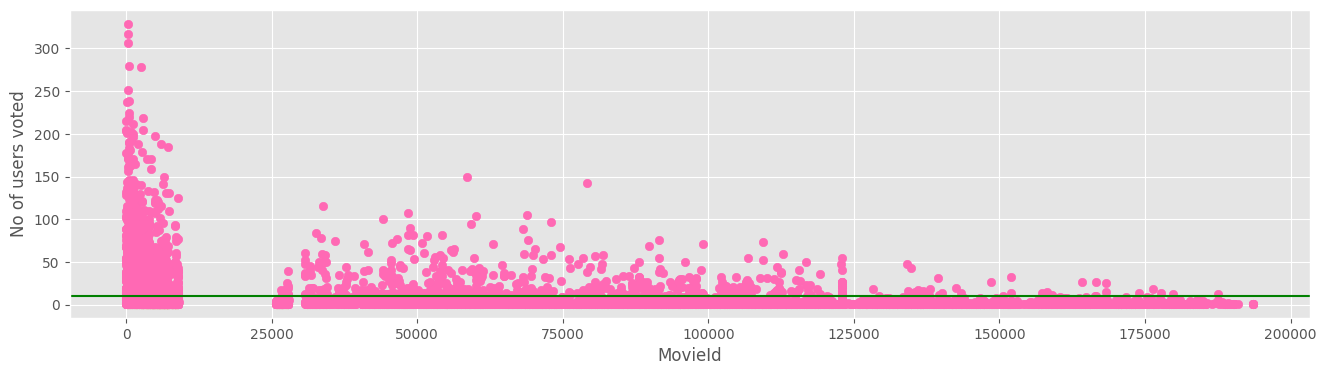

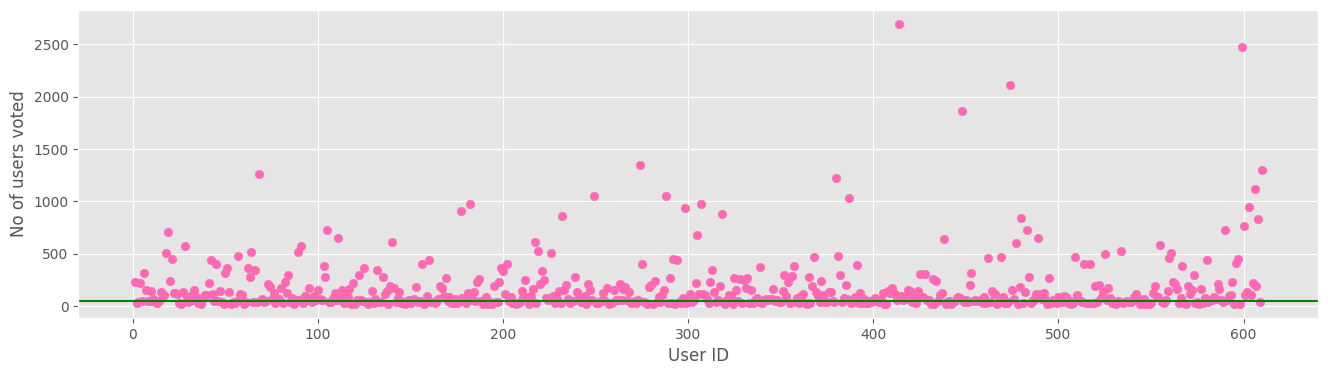

Dataset shape: (2121, 378)


userId,1,4,6,7,10,11,15,16,17,18,...,600,601,602,603,604,605,606,607,608,610
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,0.0,0.0,4.5,0.0,0.0,2.5,0.0,4.5,3.5,...,2.5,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,5.0
2,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,...,4.0,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0
3,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
5,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.5,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
6,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,4.0,...,0.0,0.0,3.0,4.0,3.0,0.0,0.0,0.0,0.0,5.0


In [ ]:
# Calculate number of votes per movie and per user
no_user_voted = ratings.groupby("movieId")['rating'].agg('count')
no_movies_voted = ratings.groupby("userId")['rating'].agg('count')

# Visualize votes per movie
plt.style.use("ggplot")
plt.figure(figsize=(16, 4))
plt.scatter(no_user_voted.index, no_user_voted, color="hotpink")
plt.axhline(y=10, color='green')
plt.xlabel("MovieId")
plt.ylabel("No of users voted")
plt.show()

# Filter movies with more than 10 votes
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index, :]

# Visualize votes per user
plt.figure(figsize=(16, 4))
plt.scatter(no_movies_voted.index, no_movies_voted, color="hotpink")
plt.axhline(y=50, color='green')
plt.xlabel("User ID")
plt.ylabel("No of users voted")
plt.show()

# Filter users with more than 50 votes
final_dataset = final_dataset.loc[:, no_movies_voted[no_movies_voted > 50].index]

# Show dataset shape and a preview
print("Dataset shape:", final_dataset.shape)
display(final_dataset.head())


In [ ]:
# Calculate sparsity of a sample array (optional)
sample = np.array([[1, 0, 0, 0, 0], [0, 0, 2, 0, 0], [0, 0, 4, 0, 0]])
sparsity = 1.0 - (np.count_nonzero(sample) / float(sample.size))
print("Sparsity of sample data:", sparsity)


Sparsity of sample data: 0.8


In [ ]:
# Convert the final dataset to a Compressed Sparse Row (CSR) matrix
csr_data = csr_matrix(final_dataset.values)
final_dataset.reset_index(inplace=True)  # Reset index for easier access to movieId


In [ ]:
# Initialize and fit the KNN model
knn = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn.fit(csr_data)


NearestNeighbors(algorithm='brute', metric='cosine', n_jobs=-1, n_neighbors=20)

In [ ]:
# Function to get movie recommendations based on user input
def get_recommendation(movie_name):
    # Convert the movie name to lowercase for case-insensitive matching
    movie_name = movie_name.lower()

    # Find all matching movies
    movie_list = movies[movies['title'].str.lower().str.contains(movie_name)]

    if len(movie_list):
        # Get the movie ID and corresponding index in final_dataset
        movie_idx = movie_list.iloc[0]['movieId']
        movie_idx = final_dataset[final_dataset['movieId'] == movie_idx].index[0]

        # Use KNN to find similar movies
        distance, indices = knn.kneighbors(csr_data[movie_idx], n_neighbors=11)

        # Prepare a list of recommended movies
        rec_movies_indices = sorted(list(zip(indices.squeeze().tolist(), distance.squeeze().tolist())), key=lambda x: x[1])[1:]
        recommended_movies = []

        for val in rec_movies_indices:
            movie_idx = final_dataset.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == movie_idx].index
            recommended_movies.append({'Title': movies.iloc[idx]['title'].values[0], 'Distance': val[1]})

        # Return the recommendations as a DataFrame
        df = pd.DataFrame(recommended_movies, index=range(1, 11))
        return df
    else:
        return "Movie not found..."


In [ ]:
# Function to prompt the user and display recommendations
def recommend_movies():
    movie_name = input("Enter your favorite movie: ")
    df = get_recommendation(movie_name)
    if isinstance(df, pd.DataFrame):
        print(df.to_string(index=False))
    else:
        print(df)

# Run the recommendation prompt
recommend_movies()


Enter your favorite movie: interstellar
                           Title  Distance
         Django Unchained (2012)  0.326071
   Dark Knight Rises, The (2012)  0.338903
Grand Budapest Hotel, The (2014)  0.356780
                Inception (2010)  0.376187
            Avengers, The (2012)  0.386820
         Edge of Tomorrow (2014)  0.390902
       The Imitation Game (2014)  0.391242
              The Martian (2015)  0.398055
       Mad Max: Fury Road (2015)  0.409325
                 Deadpool (2016)  0.416786


# Running the Code
Upload movies.csv and ratings.csv files to your environment (e.g., /content/ directory in Colab).

Run Each Cell Sequentially to execute the code step-by-step. Ensure the libraries are loaded, data is preprocessed, and the KNN model is trained before testing the recommendation system.

# **content base recommendation**

In [ ]:
import numpy as np
import pandas as pd
import difflib
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
# loading the data from the csv file to apandas dataframe
movies_data = pd.read_csv('/content/movies content based.csv')

In [ ]:
# printing the first 5 rows of the dataframe
movies_data.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


In [ ]:
# number of rows and columns in the data frame

movies_data.shape

(4803, 24)

In [ ]:
# selecting the relevant features for recommendation

selected_features = ['genres','keywords','tagline','cast','director']
print(selected_features)

['genres', 'keywords', 'tagline', 'cast', 'director']


In [ ]:
# replacing the null valuess with null string

for feature in selected_features:
  movies_data[feature] = movies_data[feature].fillna('')

In [ ]:
# combining all the 5 selected features

combined_features = movies_data['genres']+' '+movies_data['keywords']+' '+movies_data['tagline']+' '+movies_data['cast']+' '+movies_data['director']

In [ ]:
print(combined_features)

0       Action Adventure Fantasy Science Fiction cultu...
1       Adventure Fantasy Action ocean drug abuse exot...
2       Action Adventure Crime spy based on novel secr...
3       Action Crime Drama Thriller dc comics crime fi...
4       Action Adventure Science Fiction based on nove...
                              ...                        
4798    Action Crime Thriller united states\u2013mexic...
4799    Comedy Romance  A newlywed couple's honeymoon ...
4800    Comedy Drama Romance TV Movie date love at fir...
4801      A New Yorker in Shanghai Daniel Henney Eliza...
4802    Documentary obsession camcorder crush dream gi...
Length: 4803, dtype: object


In [ ]:
# converting the text data to feature vectors

vectorizer = TfidfVectorizer()

In [ ]:
feature_vectors = vectorizer.fit_transform(combined_features)

In [ ]:
print(feature_vectors)

  (0, 201)	0.07860022416510505
  (0, 274)	0.09021200873707368
  (0, 5274)	0.11108562744414445
  (0, 13599)	0.1036413987316636
  (0, 5437)	0.1036413987316636
  (0, 3678)	0.21392179219912877
  (0, 3065)	0.22208377802661425
  (0, 5836)	0.1646750903586285
  (0, 14378)	0.33962752210959823
  (0, 16587)	0.12549432354918996
  (0, 3225)	0.24960162956997736
  (0, 14271)	0.21392179219912877
  (0, 4945)	0.24025852494110758
  (0, 15261)	0.07095833561276566
  (0, 16998)	0.1282126322850579
  (0, 11192)	0.09049319826481456
  (0, 11503)	0.27211310056983656
  (0, 13349)	0.15021264094167086
  (0, 17007)	0.23643326319898797
  (0, 17290)	0.20197912553916567
  (0, 13319)	0.2177470539412484
  (0, 14064)	0.20596090415084142
  (0, 16668)	0.19843263965100372
  (0, 14608)	0.15150672398763912
  (0, 8756)	0.22709015857011816
  :	:
  (4801, 403)	0.17727585190343229
  (4801, 4835)	0.24713765026964
  (4801, 17266)	0.28860981849329476
  (4801, 13835)	0.27870029291200094
  (4801, 13175)	0.28860981849329476
  (4801, 171

Cosine similarity

In [ ]:
# getting the similarity scores using cosine similarity

similarity = cosine_similarity(feature_vectors)

In [ ]:
print(similarity)

[[1.         0.07219487 0.037733   ... 0.         0.         0.        ]
 [0.07219487 1.         0.03281499 ... 0.03575545 0.         0.        ]
 [0.037733   0.03281499 1.         ... 0.         0.05389661 0.        ]
 ...
 [0.         0.03575545 0.         ... 1.         0.         0.02651502]
 [0.         0.         0.05389661 ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.02651502 0.         1.        ]]


In [ ]:
print(similarity.shape)

(4803, 4803)


getting movie name from the user

In [ ]:
# getting the movie name from the user

movie_name = input(' Enter your favourite movie name : ')

 Enter your favourite movie name : interstellar


In [ ]:
# creating a list with all the movie names given in the dataset

list_of_all_titles = movies_data['title'].tolist()
print(list_of_all_titles)

['Avatar', "Pirates of the Caribbean: At World's End", 'Spectre', 'The Dark Knight Rises', 'John Carter', 'Spider-Man 3', 'Tangled', 'Avengers: Age of Ultron', 'Harry Potter and the Half-Blood Prince', 'Batman v Superman: Dawn of Justice', 'Superman Returns', 'Quantum of Solace', "Pirates of the Caribbean: Dead Man's Chest", 'The Lone Ranger', 'Man of Steel', 'The Chronicles of Narnia: Prince Caspian', 'The Avengers', 'Pirates of the Caribbean: On Stranger Tides', 'Men in Black 3', 'The Hobbit: The Battle of the Five Armies', 'The Amazing Spider-Man', 'Robin Hood', 'The Hobbit: The Desolation of Smaug', 'The Golden Compass', 'King Kong', 'Titanic', 'Captain America: Civil War', 'Battleship', 'Jurassic World', 'Skyfall', 'Spider-Man 2', 'Iron Man 3', 'Alice in Wonderland', 'X-Men: The Last Stand', 'Monsters University', 'Transformers: Revenge of the Fallen', 'Transformers: Age of Extinction', 'Oz: The Great and Powerful', 'The Amazing Spider-Man 2', 'TRON: Legacy', 'Cars 2', 'Green Lant

In [ ]:
# finding the close match for the movie name given by the user

find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles)
print(find_close_match)

['Interstellar', 'Cinderella', 'Cinderella Man']


In [ ]:
close_match = find_close_match[0]
print(close_match)

Interstellar


In [ ]:
# finding the index of the movie with title

index_of_the_movie = movies_data[movies_data.title == close_match]['index'].values[0]
print(index_of_the_movie)

95


In [ ]:
# getting a list of similar movies

similarity_score = list(enumerate(similarity[index_of_the_movie]))
print(similarity_score)

[(0, 0.04690381740822484), (1, 0.03831402197003225), (2, 0.01809872484700824), (3, 0.2063965588105755), (4, 0.05112238641018321), (5, 0.012527150972255686), (6, 0.016258186422473776), (7, 0.037761087051916754), (8, 0.017900682010517175), (9, 0.050006012315209326), (10, 0.08863206785872221), (11, 0.0066365528500540345), (12, 0.007627939316714521), (13, 0.02869497888157046), (14, 0.09823526879515909), (15, 0.02980193032467172), (16, 0.035805537397456975), (17, 0.03898384042105927), (18, 0.03267873440522361), (19, 0.067669078442589), (20, 0.03260029452442331), (21, 0.00626972714904622), (22, 0.010921731648286146), (23, 0.014453447316669452), (24, 0.032752628704463514), (25, 0.04408934355484746), (26, 0.028327077952931573), (27, 0.05690903506968484), (28, 0.03181738382945615), (29, 0.018508100387308005), (30, 0.007529314973734755), (31, 0.04584980886581944), (32, 0.08210532595586012), (33, 0.03752646609764682), (34, 0.019305361415044058), (35, 0.039015944225575035), (36, 0.0464325749889423

In [ ]:
len(similarity_score)

4803

In [ ]:
# sorting the movies based on their similarity score

sorted_similar_movies = sorted(similarity_score, key = lambda x:x[1], reverse = True)
print(sorted_similar_movies)

[(95, 1.0000000000000007), (3, 0.2063965588105755), (634, 0.18305727680325745), (270, 0.17926326535776166), (3688, 0.17416027328313544), (1102, 0.16409444892599875), (123, 0.15830477814282753), (125, 0.15584658890247316), (3439, 0.15542093215931804), (149, 0.15151151202374075), (108, 0.14978336276354937), (365, 0.14645132725077775), (43, 0.14507272604502502), (2793, 0.14495819050010567), (3645, 0.14451298851957955), (1446, 0.14207020181538982), (437, 0.13926153929853902), (2285, 0.13799780907978465), (93, 0.13725112503164708), (1196, 0.13093937379882303), (119, 0.12878733973574516), (2366, 0.12731611858110803), (2817, 0.12669302906920663), (471, 0.12587742190082596), (1296, 0.12477145465776532), (3373, 0.12439808347631733), (3413, 0.12350233681003059), (2677, 0.12269340218073398), (1611, 0.12235094813764688), (886, 0.12193675629878876), (2212, 0.12080086034046031), (4608, 0.12074938017414971), (1645, 0.12019513801384647), (65, 0.12007985540794444), (2790, 0.11981682803258178), (1018, 0

In [ ]:
# print the name of similar movies based on the index

print('Movies suggested for you : \n')

i = 1

for movie in sorted_similar_movies:
  index = movie[0]
  title_from_index = movies_data[movies_data.index==index]['title'].values[0]
  if (i<30):
    print(i, '.',title_from_index)
    i+=1

Movies suggested for you : 

1 . Interstellar
2 . The Dark Knight Rises
3 . The Matrix
4 . The Martian
5 . Dear Frankie
6 . Argo
7 . The Matrix Revolutions
8 . The Matrix Reloaded
9 . The Terminator
10 . Armageddon
11 . Terminator Genisys
12 . Contact
13 . Terminator Salvation
14 . The Killer Inside Me
15 . Gandhi, My Father
16 . The Tree of Life
17 . Get Smart
18 . Back to the Future
19 . Terminator 3: Rise of the Machines
20 . The Prestige
21 . Batman Begins
22 . Dragonslayer
23 . WarGames
24 . Little Nicky
25 . Superman III
26 . The Other Side of Heaven
27 . House at the End of the Street
28 . Good Deeds
29 . Mortal Kombat: Annihilation


In [ ]:
movie_name = input(' Enter your favourite movie name : ')

list_of_all_titles = movies_data['title'].tolist()

find_close_match = difflib.get_close_matches(movie_name, list_of_all_titles)

close_match = find_close_match[0]

index_of_the_movie = movies_data[movies_data.title == close_match]['index'].values[0]

similarity_score = list(enumerate(similarity[index_of_the_movie]))

sorted_similar_movies = sorted(similarity_score, key = lambda x:x[1], reverse = True)

print('Movies suggested for you : \n')

i = 1

for movie in sorted_similar_movies:
  index = movie[0]
  title_from_index = movies_data[movies_data.index==index]['title'].values[0]
  if (i<30):
    print(i, '.',title_from_index)
    i+=1

 Enter your favourite movie name : interstellar
Movies suggested for you : 

1 . Interstellar
2 . The Dark Knight Rises
3 . The Matrix
4 . The Martian
5 . Dear Frankie
6 . Argo
7 . The Matrix Revolutions
8 . The Matrix Reloaded
9 . The Terminator
10 . Armageddon
11 . Terminator Genisys
12 . Contact
13 . Terminator Salvation
14 . The Killer Inside Me
15 . Gandhi, My Father
16 . The Tree of Life
17 . Get Smart
18 . Back to the Future
19 . Terminator 3: Rise of the Machines
20 . The Prestige
21 . Batman Begins
22 . Dragonslayer
23 . WarGames
24 . Little Nicky
25 . Superman III
26 . The Other Side of Heaven
27 . House at the End of the Street
28 . Good Deeds
29 . Mortal Kombat: Annihilation


# Conclusion:

In comparing these two models, we might observe:

 **Collaborative filtering** tends to perform better in settings with substantial user engagement and a well-populated dataset, making it highly effective for more personalized recommendations. However, it suffers from sparsity issues and can struggle in scenarios where the movie or user has limited data.

**Content-based filtering** offers a strong alternative in cold-start situations or where computational resources are limited. It’s well-suited for making recommendations based on specific genres or styles the user enjoys but may lack the variety found in collaborative filtering.